# Técnicas que serão utilizadas

* Feature selection (Heatmat)
* Divisão de dados em treino e teste
* Label Encoder (Transforma valores categoricos em númericos)
* KNeighbors Regressor (Pega a média dos valores mais proximos)
* Random Forest (Conjunto de Árvores de decisão)
* Curva de aprendizado (Ánalise de Under/Overfiting)
* Ánalise de overfiting ou underfiting
* Pipeline
* Otimização de Hiperparâmetros
* Cross Validation

# Entendendo os dados

In [1]:
# Importando as bibliotecas que serão utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Carregado base de dados
df = pd.read_csv('ds_salaries.csv')

In [3]:
# Entendendo a base de dados
df.shape

(3755, 11)

In [4]:
# Visualizando os dados
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


Nossa objetivo nesse dataset é prever o valor da coluna "salary_in_usd" a partir dos outros dados, para isso vamos excluir a coluna "salary" que torna a solução trivial que seria so uma conversão de moeda.

In [5]:
df = df.drop(columns=['salary'])

In [6]:
# Verificando se existem valores nulos
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [7]:
# Verificando os tipos das colunas
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [8]:
# Verificando o número de ocorrências das colunas não númericas
df.select_dtypes(exclude='number').nunique()

experience_level       4
employment_type        4
job_title             93
salary_currency       20
employee_residence    78
company_location      72
company_size           3
dtype: int64

Ao observar esse número de ocorrência das colunas categoricas é possível observar que a coluna "job_title" pode ser um problema.

In [9]:
df['job_title'].unique()

array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Sc

É possível ver algumas redundâncias incoerrentes com a existência de uma coluna que diz o nível de senioriade, então organizamos melhor esses dados.

In [10]:
df['job_title'].value_counts(normalize=True)[:10]

Data Engineer                0.276964
Data Scientist               0.223702
Data Analyst                 0.162983
Machine Learning Engineer    0.076964
Analytics Engineer           0.027430
Data Architect               0.026897
Research Scientist           0.021838
Data Science Manager         0.015446
Applied Scientist            0.015446
Research Engineer            0.009854
Name: job_title, dtype: float64

In [11]:
data_eng = ['Data Architect']
data_sci = ['Applied Scientist','Research Engineer','Research Scientist','Data Science Manager']
data_ana = ['Analytics Engineer']

df['job_title'] = df['job_title'].replace(data_sci, 'Data Scientist')
df['job_title'] = df['job_title'].replace(data_eng, 'Data Engineer')
df['job_title'] = df['job_title'].replace(data_ana, 'Data Analyst')

jobs = ['Data Engineer','Data Scientist','Data Analyst','Machine Learning Engineer']

df.drop(df[~df['job_title'].isin(jobs)].index, inplace = True)

In [12]:
df['job_title'].value_counts(normalize=True)

Data Engineer                0.354348
Data Scientist               0.333851
Data Analyst                 0.222050
Machine Learning Engineer    0.089752
Name: job_title, dtype: float64

Selecionamos os 4 principais para serem utilizados, foram realocados os outros com maiores ocorrências e removidos os restantes.

In [13]:
df.describe()

,work_year,salary_in_usd,remote_ratio
count,3220.000000,3220.000000,3220.000000
mean,2022.415839,140210.826398,44.937888
std,0.651948,60278.903317,48.868806
min,2020.000000,5679.000000,0.000000
25%,2022.000000,100000.000000,0.000000
50%,2022.000000,136000.000000,0.000000
75%,2023.000000,178637.500000,100.000000
max,2023.000000,450000.000000,100.000000


# Organizando os dados

Separando algumas possibilidades de features e o target.

In [14]:
# Divisão de dados em features e target
# Selecionando todas as colunas como features
X = df.drop(columns='salary_in_usd', axis=1)
y = df['salary_in_usd']

Transformando os dados de categoricos para númericos

In [15]:
# Transformação de dados categoricos para númericos utilizando o Label Encoder

encoder = LabelEncoder()
categorical_features = list(X.columns)
for each in categorical_features:
    X[each] = encoder.fit_transform(X[each])

In [16]:
# Divisão dOS dados 80%  para treino e 20% para teste

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 2)

# Treinando o modelo

In [17]:
# Utilizando o algoritmo Random Forest para caso de regressão
# Algoritmo que cria várias árvores de decisão para criar um modelo para os dados.
# Utilizando random_state 2 para manter o padrão em casos futuros

modelo = RandomForestRegressor(random_state=2)
modelo.fit(X_train,y_train)

RandomForestRegressor(random_state=2)

In [18]:
# Predição dos dados de teste
y_pred = modelo.predict(X_test)

In [19]:
# Avaliando desempenho do modelo

print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

0.3890497862133584
36622.87957123584


O modelo so influencia em 39% do valor de salário, e tem um erro médio de 36.6 mil doláres +-26% do valor médio

# Otimizando Hiperparâmetros

In [20]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [21]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

rf_random.fit(X_train, y_train)

print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': False}  



In [22]:
randmf = RandomForestRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf= 4, max_features = 'sqrt', max_depth= 110, bootstrap=False) 
randmf.fit( X_train, y_train) 

RandomForestRegressor(bootstrap=False, max_depth=110, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=10)

In [23]:
y_train_pred_rf = randmf.predict(( X_train))
y_test_pred_rf = randmf.predict(( X_test ))

In [24]:
print(r2_score(y_test, randmf.predict((X_test))))
print(mean_absolute_error(y_test, randmf.predict((X_test))))

0.3937877262824939
36556.794089857336


In [25]:
# Verificação da influência de cada feature

feat_imp = modelo.feature_importances_
feat_name = X.columns

for i in range(len(X.columns)):
    print(f'{feat_name[i]}: {str(round(feat_imp[i]*100,2))}%')


work_year: 5.05%
experience_level: 16.56%
employment_type: 0.17%
job_title: 16.88%
salary_currency: 11.62%
employee_residence: 39.57%
remote_ratio: 5.58%
company_location: 2.07%
company_size: 2.51%


# Visualizando os resultados

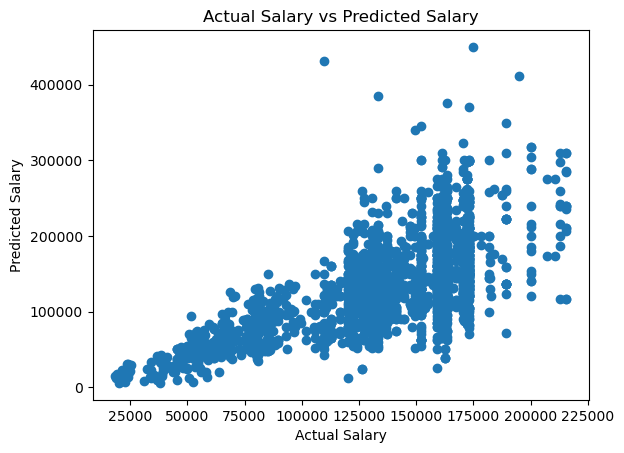

In [26]:
plt.scatter(y_train_pred_rf, y_train)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual Salary vs Predicted Salary")
plt.show()

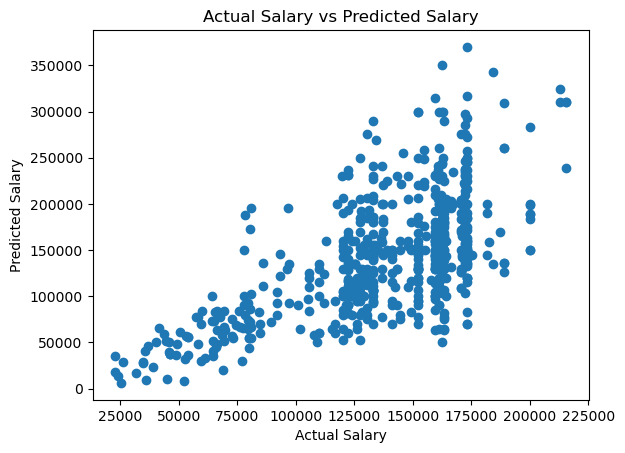

In [27]:
plt.scatter(y_test_pred_rf, y_test)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual Salary vs Predicted Salary")
plt.show()

In [28]:
df_selecao = pd.DataFrame(X_train, columns=X_train.columns)
df_selecao['salary_in_usd'] = y_train
corr = df_selecao.corr(method='pearson')

<AxesSubplot:>

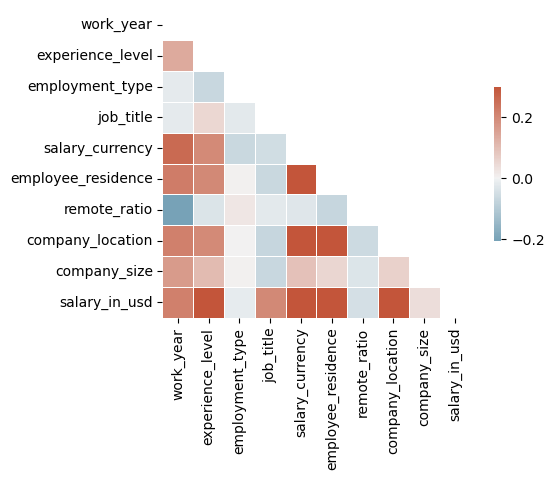

In [29]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [30]:
indice_features = corr['salary_in_usd'].abs().sort_values(ascending=False).index

In [31]:
def curva_aprendizado_selecao_feature(range_features, indice_features, X_train, X_test, y_train, y_test):
    erros_train = []
    erros_test = []
    for limite_feature in range_features:
        X_train_temp = X_train[indice_features[1:limite_feature]]
        X_test_temp = X_test[indice_features[1:limite_feature]]
        
        modelo = RandomForestRegressor(random_state=42, max_depth=4)
        modelo.fit(X_train_temp, y_train)
        y_pred_train = modelo.predict(X_train_temp)
        y_pred_test = modelo.predict(X_test_temp)
        
        erros_train.append(mean_absolute_error(y_train, y_pred_train))
        erros_test.append(mean_absolute_error(y_test, y_pred_test))
        
    return range_features, erros_train, erros_test

In [32]:
range_features, erros_train, erros_test = curva_aprendizado_selecao_feature(list(range(2, 9)), indice_features,X_train, X_test, y_train, y_test)

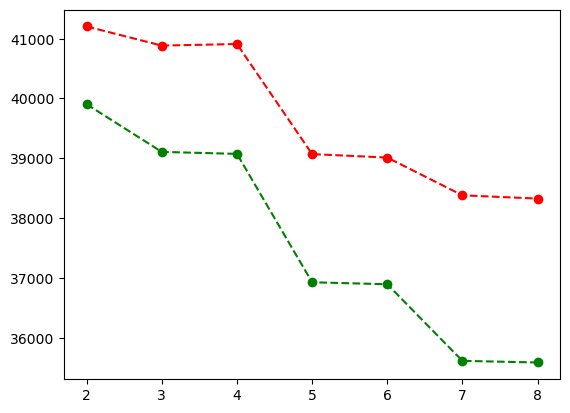

In [33]:
plt.plot(range_features, erros_train, 'o--', color='g')
plt.plot(range_features, erros_test, 'o--', color='r')

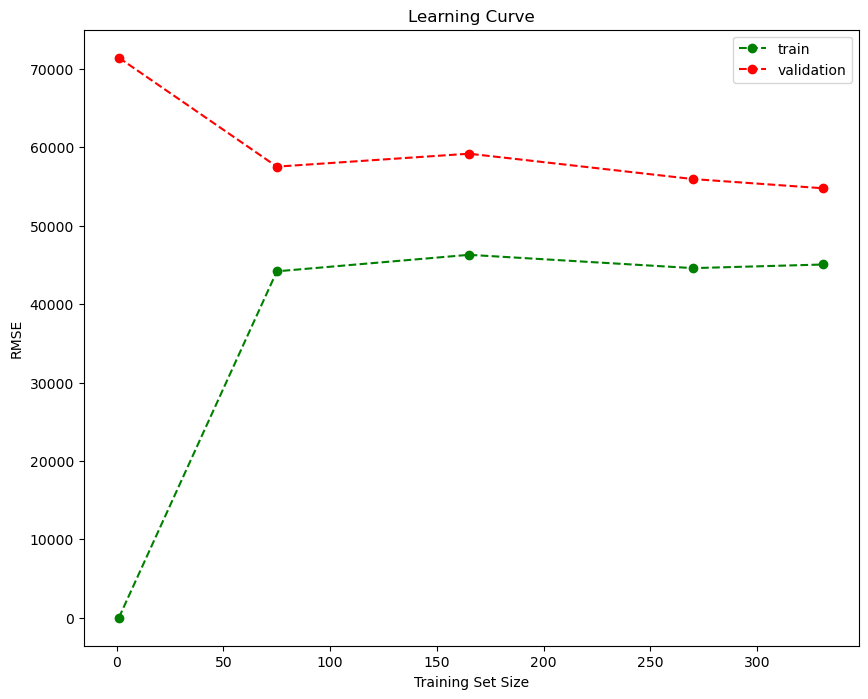

In [34]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [1, 75, 165, 270, 331]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, 'o--', label="train",color='g')
plt.plot(train_sizes, test_mean, 'o--', label="validation",color='r')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()


Os dados de teste performam mal e seguem piorando eo os de treino tambem não demonstram ter aprendido 

In [35]:
from sklearn.neighbors import KNeighborsRegressor

X_train2 = X_train.drop(columns='salary_in_usd')
modelo2 = KNeighborsRegressor()
modelo2.fit(X_train2, y_train)
y_train_pred_knn = modelo2.predict(X_train2)
y_test_pred_knn = modelo2.predict(X_test)
score = r2_score(y_test, y_pred)
print(score)
print(mean_absolute_error(y_test, y_pred))

0.3890497862133584
36622.87957123584


In [36]:
modelo.n_features_in_


9

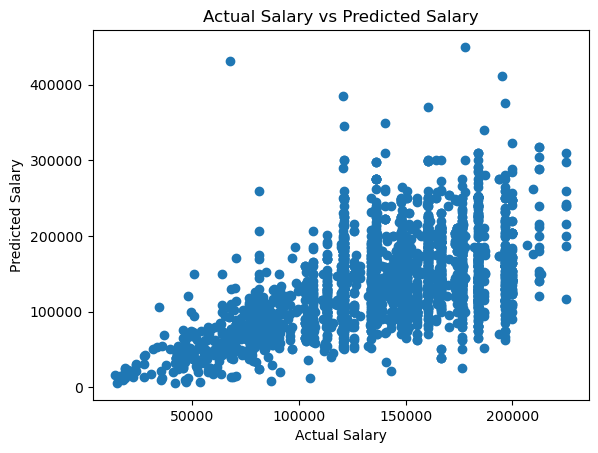

In [37]:
plt.scatter(y_train_pred_knn, y_train)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual Salary vs Predicted Salary")
plt.show()

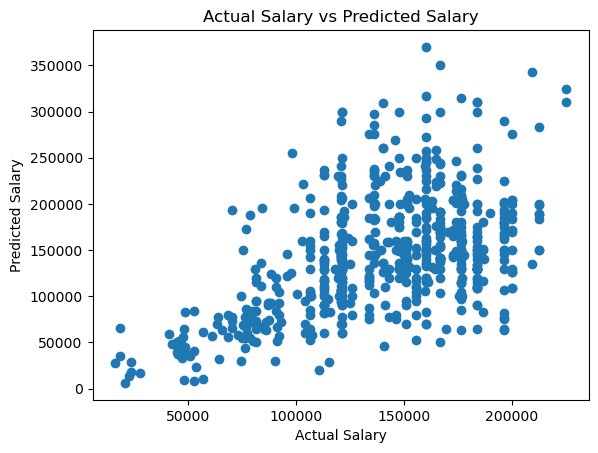

In [38]:
plt.scatter(y_test_pred_knn, y_test)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual Salary vs Predicted Salary")
plt.show()

In [39]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train2, y_train)  #fit the model
    pred = model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 62526.103935508705
RMSE value for k=  2 is: 55647.64957554111
RMSE value for k=  3 is: 56610.40209586322
RMSE value for k=  4 is: 54691.0796123269
RMSE value for k=  5 is: 54608.56606523825
RMSE value for k=  6 is: 53595.133051466444
RMSE value for k=  7 is: 53161.373045629276
RMSE value for k=  8 is: 53518.693961330224
RMSE value for k=  9 is: 53244.21427333499
RMSE value for k=  10 is: 52926.33129943963
RMSE value for k=  11 is: 52093.03935587629
RMSE value for k=  12 is: 52421.77775690466
RMSE value for k=  13 is: 52292.38361723919
RMSE value for k=  14 is: 51953.76810568807
RMSE value for k=  15 is: 51906.42535861871
RMSE value for k=  16 is: 51857.86311863515
RMSE value for k=  17 is: 51853.89323087064
RMSE value for k=  18 is: 51385.71631128875
RMSE value for k=  19 is: 51442.51952810299
RMSE value for k=  20 is: 51601.211715989324
RMSE value for k=  21 is: 51767.324469191204
RMSE value for k=  22 is: 51882.34754364821
RMSE value for k=  23 is: 51967.5038

<AxesSubplot:>

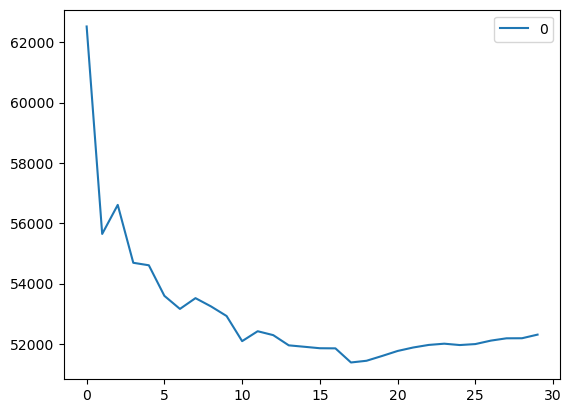

In [44]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [45]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train2,y_train)
model.best_params_

{'n_neighbors': 8}